## Fault Diagnosis of Gear

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

## Read our data from s3 bucket

In [2]:
import boto3 
BUCKET_NAME = 'moursi'

#refrance to s3
s3 = boto3.client('s3')

# list all buckets
bucket_resp = s3.get_object(Bucket = BUCKET_NAME , Key = 'Gear_Fault_data.csv' )

df = pd.read_csv(bucket_resp['Body'])
print(df.tail(5))

              a1        a2        a3       a4  load fault
2031611 -1.81021 -1.338130 -4.232510  1.10648   0.4     H
2031612 -4.90746  1.820860 -3.727170  3.97924   0.4     H
2031613 -1.67954  0.614342  0.831932  4.51194   0.4     H
2031614  3.98700  3.330530  2.109150  2.50351   0.4     H
2031615  2.34664  1.061480  0.211121  3.44222   0.4     H


In [3]:
df.sample(10, random_state=42)

,a1,a2,a3,a4,load,fault
1869128,5.550850,-6.427450,3.294470,-8.678180,0.8,H
1231085,-4.700810,4.511740,-1.123110,-1.763440,0.1,H
520071,-3.734800,0.839229,0.490083,1.118930,0.2,F
475852,0.801834,-0.434609,1.943100,3.077100,0.3,F
1200764,1.056290,2.092300,0.643839,1.351910,0.6,H
883920,-9.175390,1.019710,8.031090,0.160619,0.8,F
1848398,-0.163783,-1.695420,-1.358420,-15.776200,0.8,H
1556740,-7.704860,-2.877200,-1.774140,-3.426520,0.2,H
296683,6.526790,5.927800,-4.122180,3.366220,0.0,F
1509271,8.968030,-7.492700,1.103980,-0.292539,0.2,H


## Scale the data

In [4]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
df.iloc[:,:-2]=scaler.fit_transform(df.iloc[:,:-2])

df

,a1,a2,a3,a4,load,fault
0,-0.491502,0.482748,0.870407,-1.398452,0.7,F
1,-0.003796,-1.461353,0.195935,-0.963093,0.7,F
2,0.639098,1.215194,-0.381368,0.247432,0.7,F
3,0.003189,0.006324,0.008312,0.154873,0.7,F
4,0.065195,-1.203280,-0.274533,0.240933,0.7,F
...,...,...,...,...,...,...
2031611,-0.245747,-0.301985,-1.031719,0.244629,0.4,H
2031612,-0.665360,0.411565,-0.908773,0.879697,0.4,H
2031613,-0.228044,0.139038,0.200423,0.997458,0.4,H
2031614,0.539655,0.752567,0.511161,0.553464,0.4,H


In [5]:
X = df.iloc[::100,:-1]
Y = df.iloc[::100,-1]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 20317 samples in 0.004s...
[t-SNE] Computed neighbors for 20317 samples in 0.621s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20317
[t-SNE] Computed conditional probabilities for sample 2000 / 20317
[t-SNE] Computed conditional probabilities for sample 3000 / 20317
[t-SNE] Computed conditional probabilities for sample 4000 / 20317
[t-SNE] Computed conditional probabilities for sample 5000 / 20317
[t-SNE] Computed conditional probabilities for sample 6000 / 20317
[t-SNE] Computed conditional probabilities for sample 7000 / 20317
[t-SNE] Computed conditional probabilities for sample 8000 / 20317
[t-SNE] Computed conditional probabilities for sample 9000 / 20317
[t-SNE] Computed conditional probabilities for sample 10000 / 20317
[t-SNE] Computed conditional probabilities for sample 11000 / 20317
[t-SNE] Computed conditional probabilities for sample 12000 / 20317
[t-SNE] Computed conditional probabilities for sa

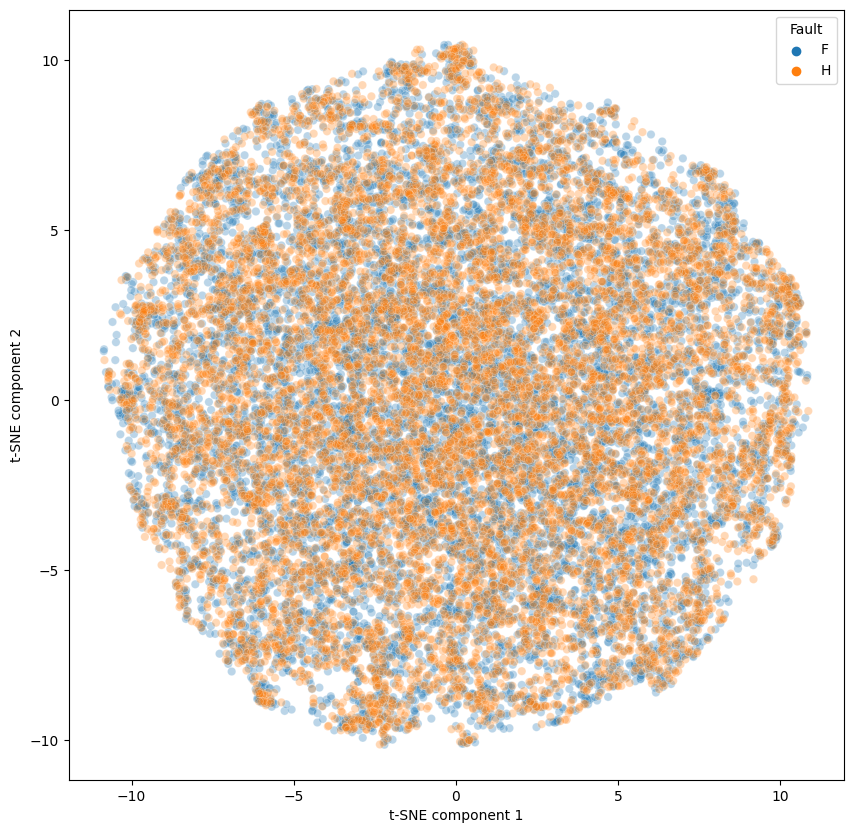

In [6]:
from sklearn.manifold import TSNE
X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(X)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['t-SNE component 1', 't-SNE component 2'])

tSNEdf['Fault']=np.array(Y)


# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['t-SNE component 1'],y=tSNEdf['t-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,shuffle=True)

## Random Forest Model


In [8]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train,y_train)

RandomForestClassifier()

In [9]:
# On training Data
clf.score(X_train,y_train)

1.0

## Performance of the proposed model


In [10]:
clf.score(X_test,y_test)

0.5008202099737533

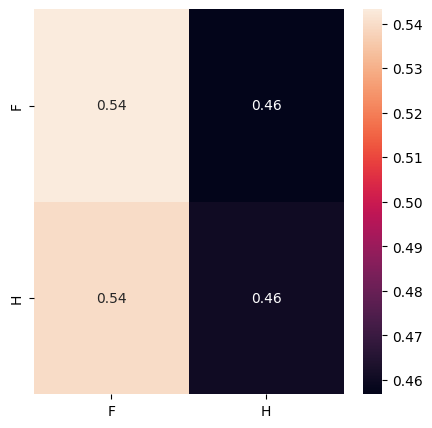

In [11]:
y_pred = clf.predict(X_test)


from sklearn.metrics import confusion_matrix


plt.figure(figsize=(5,5))
cm = confusion_matrix(y_test, y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=clf.classes_,yticklabels=clf.classes_)
plt.show()